In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, losses
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

import numpy as np
from numpy.linalg import pinv

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar os dados
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Adicionar uma dimensão de canal
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

11490434/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
# Dimensões de entrada
input_shape = (28, 28, 1)

# Codificador (Encoder)
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14x32
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7x64
encoder_output = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

# Decodificador (Decoder)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_output)
x = layers.UpSampling2D((2, 2))(x)  # 14x14x64
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 28x28x32
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # 28x28x1

decoded = models.Model(encoder_output, decoder_output)

autoencoder = models.Model(encoder_input, decoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         7385

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 5s 15ms/step - loss: 0.1270 - val_loss: 0.0786
Epoch 2/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0756 - val_loss: 0.0730
Epoch 3/10
235/235 [==============================] - 3s 15ms/step - loss: 0.0717 - val_loss: 0.0700
Epoch 4/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0699 - val_loss: 0.0686
Epoch 5/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0689 - val_loss: 0.0677
Epoch 6/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0681 - val_loss: 0.0672
Epoch 7/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0676 - val_loss: 0.0668
Epoch 8/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0671 - val_loss: 0.0672
Epoch 9/10
235/235 [==============================] - 4s 15ms/step - loss: 0.0667 - val_loss: 0.0659
Epoch 10/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0664 - val_lo

In [ ]:
def plot_loss_function(history):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Loss (training data)')
  plt.plot(history.history['val_loss'], label='Loss (validation data)')
  plt.title('Loss function')
  plt.ylabel('Loss value')
  plt.xlabel('Epoch')
  plt.legend(loc="upper right")
  plt.show()

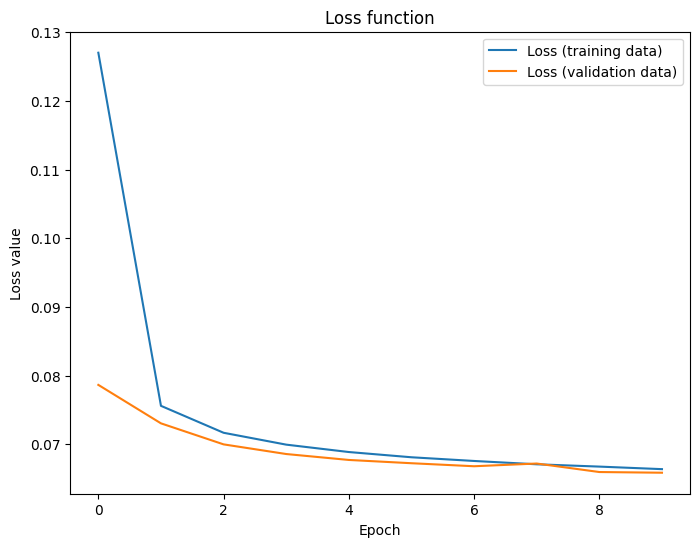

In [ ]:
plot_loss_function(history)

313/313 [==============================] - 1s 2ms/step


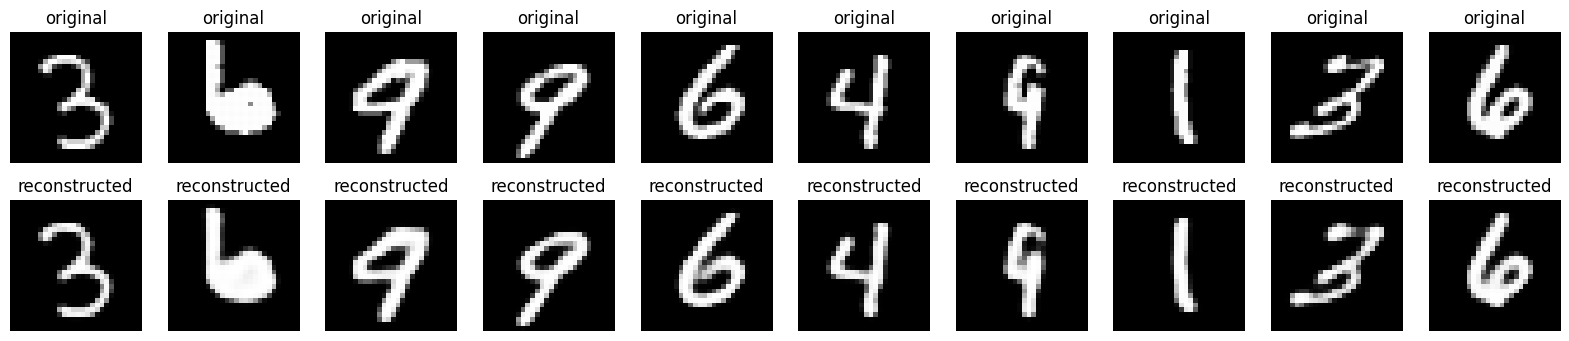

In [ ]:
# Fazer previsões com o autoencoder
decoded_imgs = autoencoder.predict(x_test)

# Visualizar os resultados
n = 10  # Número de imagens a serem exibidas
indices = np.random.randint(0, len(x_test), n)  # Índices aleatórios

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[indices[i]].reshape(28, 28), cmap='gray')
    plt.title("original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[indices[i]].reshape(28, 28), cmap='gray')
    plt.title("reconstructed")
    plt.axis("off")
plt.show()

In [ ]:
np.random.seed(1349)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

# Achatar as imagens reconstruídas para o ELM
decoded_imgs_flat = decoded_imgs.reshape(decoded_imgs.shape[0], -1)

# One-hot encoding das labels
encoder_onehot = OneHotEncoder(sparse=False)
y_train_onehot = encoder_onehot.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder_onehot.transform(y_test.reshape(-1, 1))

# Parâmetros do modelo ELM
input_size = decoded_imgs_flat.shape[1]
hidden_size = 1000  # número de neurônios na camada oculta
output_size = y_train_onehot.shape[1]

# Inicializar pesos da camada oculta aleatoriamente
W = np.random.randn(input_size, hidden_size)
b = np.random.randn(hidden_size)

# Função de ativação da camada oculta (ReLU)
def relu(x):
    return np.maximum(0, x)

# Calcular a saída da camada oculta para os dados de treino reconstruídos
H_train = relu(np.dot(decoded_imgs_flat, W) + b)

# Calcular os pesos da camada de saída usando pseudoinversa
H_pinv = pinv(H_train)
beta = np.dot(H_pinv, y_test_onehot)

# Fazer previsões no conjunto de teste usando as imagens reconstruídas
H_test = relu(np.dot(decoded_imgs_flat, W) + b)
y_pred = np.dot(H_test, beta)

# Converter as previsões para labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Avaliar a acurácia
accuracy = np.mean(y_pred_labels == y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test accuracy: 97.05%


Confusion Matrix:
[[ 970    0    1    1    0    1    3    1    3    0]
 [   0 1126    5    1    1    0    2    0    0    0]
 [   1    1 1000    2    6    0    3    8   10    1]
 [   0    0    3  978    0   10    0    7    7    5]
 [   0    0    2    0  953    0    5    0    1   21]
 [   6    1    0   12    2  856    9    0    2    4]
 [   5    3    1    0    2    5  941    0    1    0]
 [   1   11    8    3    1    2    0  992    1    9]
 [   3    5    2    9    5    8    3    2  930    7]
 [   3    7    1    7   16    3    1    8    4  959]]


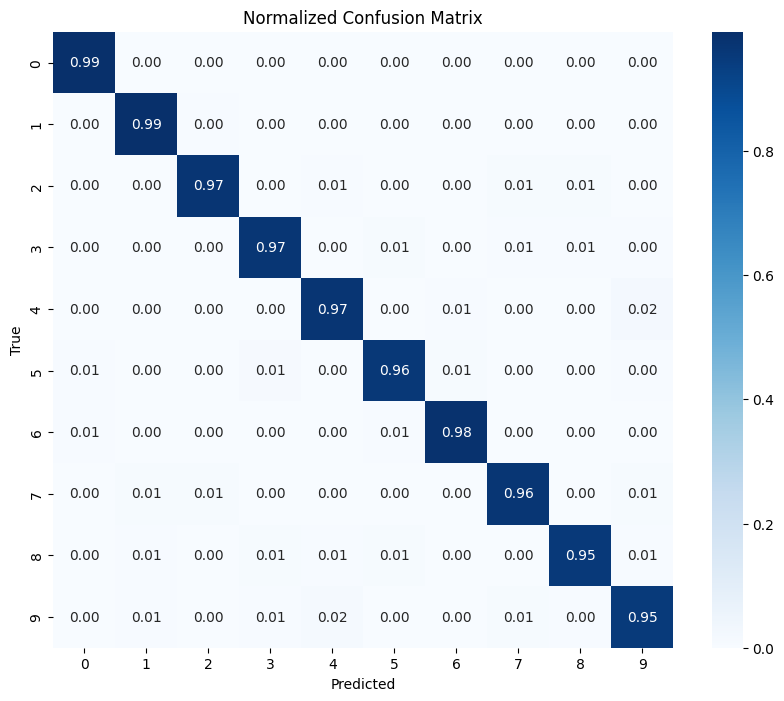

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Normalizar a matriz de confusão por linha (por classe verdadeira)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão normalizada de forma visual
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Arquiteturas do modelo:

In [ ]:
from tensorflow.keras.utils import plot_model

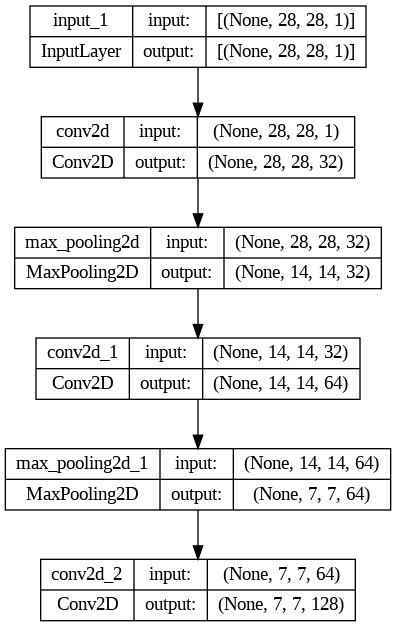

In [ ]:
plot_model(encoder, to_file='model.png', show_shapes=True, show_layer_names=True)

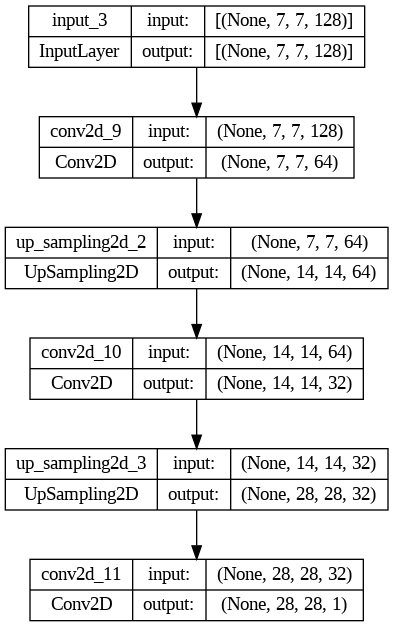

In [ ]:
plot_model(decoded, to_file='model.png', show_shapes=True, show_layer_names=True)

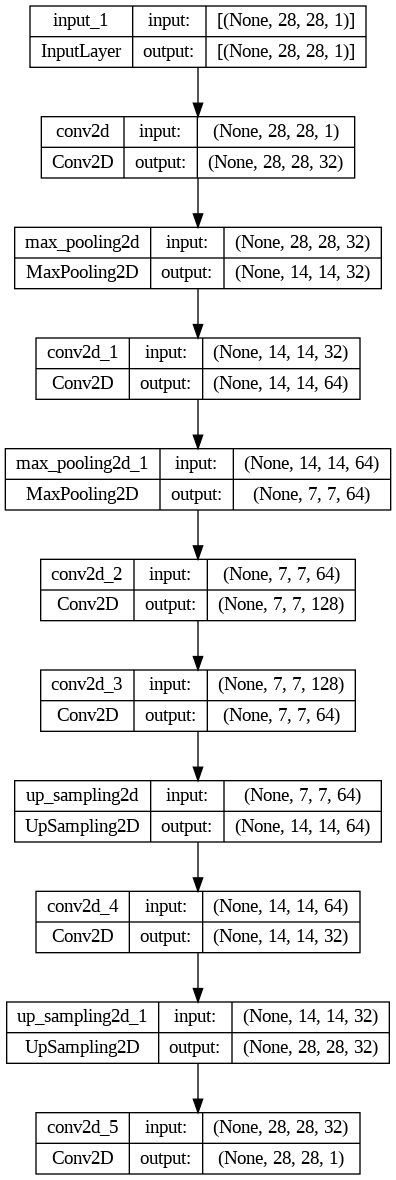

In [ ]:
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)